    ** This notebook consist of my work with MalImg DataSet.
    ** I want to demonstrate that using CNN and Vision Transformer we can achieve better results for categorization of malware
       images.
    ** Steps Planned are as follows :-
            a. Load Malware Image data into numpy matrix
            b. Generate empirical statistics associated to the input data
            c. Using Stratified Sampling logic split data into 80-20 train test split
            d. Visualize malware data for each malware class
            e. Use CNN to extract important filters 
            f. split the extracted filters into patches of image 
            g. use ViT on the image patches 
            h. train model 
            i. report results 
            j. start writing Journal 

# Load Librares

In [4]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import matplotlib.cm as cm
from sklearn import metrics
sns.set(style="whitegrid", color_codes=True)
%matplotlib inline
pd.set_option('max_colwidth', 999)
pd.set_option('display.max_columns', 999)
pd.set_option("display.max_rows", 999)
from mpl_toolkits.mplot3d import Axes3D
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split

In [60]:
import sklearn

## GPU Based Imports 

In [6]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#### Check GPU enabled 

In [7]:
if tf.test.gpu_device_name():
    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))
    print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
    print("is_built_with_gpu_support :- ",tf.test.is_built_with_gpu_support())
    print("is_built_with_cuda :- ",tf.test.is_built_with_cuda())
    print(tf.config.list_physical_devices('GPU'))
else:
    print("No GPU Found !!!!")

Default GPU Device:/device:GPU:0
Num GPUs Available:  1
is_built_with_gpu_support :-  True
is_built_with_cuda :-  True
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Tools & Utilities 

In [5]:
def stratified_sampling(input_df,
                        group=None,
                        unique_id=None,
                        parts=37,
                        train=True,
                        test=True,
                        test_per=0.3):
    if group is None:
        group = [1]
    if unique_id is None:
        print("provide unique Identifier")
        return
    train_ = []
    test_ = []
    for i in input_df[group].unique().tolist() if len(group) != 1 else group:
        split = np.array_split(
            input_df[input_df[group] == i][unique_id].unique().tolist()
            if i != 1 else input_df[unique_id].unique().tolist(), parts)
        for s in split:
            tr, te = train_test_split(s,
                                      test_size=test_per,
                                      random_state=9,
                                      shuffle=True)
            if train & test:
                train_.extend(tr)
                test.extend(te)
            elif train:
                train_.extend(tr)
            else:
                test_.extend(te)
            del tr, te
    return train_, test_

In [39]:
import pycm


def evaluate_model(Y_actual, Y_predicted):

    confusion_matrix_class = pycm.ConfusionMatrix(actual_vector=Y_actual,
                                                  predict_vector=Y_predicted)

    TPR = []
    PPV = []
    FPR = []
    FNR = []
    ACC = []
    F1 = []

    FP = confusion_matrix_class.FP.values()
    FN = confusion_matrix_class.FN.values()
    TP = confusion_matrix_class.TP.values()
    TN = confusion_matrix_class.TN.values()

    FPR_ = (sum(FP) / (sum(FP) + sum(TN)))
    FNR_ = (sum(FN) / (sum(FN) + sum(TP)))

    ACC_ = ((sum(TP) + sum(TN)) / (sum(FN) + sum(TP) + sum(TN) + sum(FP)))

    TPR.append(
        np.where((confusion_matrix_class.overall_stat['TPR Micro'] == 'None') |
                 (confusion_matrix_class.overall_stat['TPR Micro'] == np.nan),
                 -0.99, confusion_matrix_class.overall_stat['TPR Micro']))
    PPV.append(
        np.where((confusion_matrix_class.overall_stat['PPV Micro'] == 'None') |
                 (confusion_matrix_class.overall_stat['PPV Micro'] == np.nan),
                 -0.99, confusion_matrix_class.overall_stat['PPV Micro']))

    FPR.append(round(FPR_, 4))
    FNR.append(round(FNR_, 4))
    ACC.append(round(ACC_, 4))

    F1.append(
        np.where((confusion_matrix_class.overall_stat['F1 Micro'] == 'None') |
                 (confusion_matrix_class.overall_stat['F1 Micro'] == np.nan),
                 -0.99, confusion_matrix_class.overall_stat['F1 Micro']))

    for i in confusion_matrix_class.classes:

        TPR.append(
            round(
                float(
                    np.where(
                        (confusion_matrix_class.class_stat['TPR'][i] == 'None')
                        | (confusion_matrix_class.class_stat['TPR'][i]
                           == np.nan), -0.99,
                        confusion_matrix_class.class_stat['TPR'][i])), 4))

        PPV.append(
            round(
                float(
                    np.where(
                        (confusion_matrix_class.class_stat['PPV'][i] == 'None')
                        | (confusion_matrix_class.class_stat['PPV'][i]
                           == np.nan), -0.99,
                        confusion_matrix_class.class_stat['PPV'][i])), 4))

        FPR.append(
            round(
                float(
                    np.where(
                        (confusion_matrix_class.class_stat['FPR'][i] == 'None')
                        | (confusion_matrix_class.class_stat['FPR'][i]
                           == np.nan), -0.99,
                        confusion_matrix_class.class_stat['FPR'][i])), 4))
        FNR.append(
            round(
                float(
                    np.where(
                        (confusion_matrix_class.class_stat['FNR'][i] == 'None')
                        | (confusion_matrix_class.class_stat['FNR'][i]
                           == np.nan), -0.99,
                        confusion_matrix_class.class_stat['FNR'][i])), 4))

        ACC.append(
            round(
                float(
                    np.where(
                        (confusion_matrix_class.class_stat['ACC'][i] == 'None')
                        | (confusion_matrix_class.class_stat['ACC'][i]
                           == np.nan), -0.99,
                        confusion_matrix_class.class_stat['ACC'][i])), 4))
        F1.append(
            round(
                float(
                    np.where(
                        (confusion_matrix_class.class_stat['F1'][i] == 'None')
                        |
                        (confusion_matrix_class.class_stat['F1'][i] == np.nan),
                        -0.99, confusion_matrix_class.class_stat['F1'][i])),
                4))

    eval_df = pd.DataFrame()
    index = ['overall']
    index.extend(confusion_matrix_class.classes)
    eval_df['Reccall'] = TPR
    eval_df['Precision'] = PPV
    eval_df['False_Positive_Rate'] = FPR
    eval_df['False_Negative_Rate'] = FNR
    eval_df['Accuracy'] = ACC
    eval_df['F1_Score'] = F1
    eval_df.index = index

    return (eval_df)

In [40]:
def recall(y_true, y_pred):

    y_true = K.ones_like(y_true)
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    all_positives = K.sum(K.round(K.clip(y_true, 0, 1)))

    recall = true_positives / (all_positives + K.epsilon())
    return recall


def precision(y_true, y_pred):

    y_true = K.ones_like(y_true)
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))

    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def f1_score(y_true, y_pred):

    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)

    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

# Load Data

## Image To Matrix

In [8]:
batches = ImageDataGenerator().flow_from_directory(
    directory=
    'D:\\Work_Space\\Data-Sets\\malimg_dataset\\malimg_paper_dataset_imgs',
    color_mode='grayscale',
    target_size=(64, 64),
    batch_size=10000,
    seed=9)

Found 9339 images belonging to 25 classes.


### Data Statistics 

In [9]:
batches.class_indices

{'Adialer.C': 0,
 'Agent.FYI': 1,
 'Allaple.A': 2,
 'Allaple.L': 3,
 'Alueron.gen!J': 4,
 'Autorun.K': 5,
 'C2LOP.P': 6,
 'C2LOP.gen!g': 7,
 'Dialplatform.B': 8,
 'Dontovo.A': 9,
 'Fakerean': 10,
 'Instantaccess': 11,
 'Lolyda.AA1': 12,
 'Lolyda.AA2': 13,
 'Lolyda.AA3': 14,
 'Lolyda.AT': 15,
 'Malex.gen!J': 16,
 'Obfuscator.AD': 17,
 'Rbot!gen': 18,
 'Skintrim.N': 19,
 'Swizzor.gen!E': 20,
 'Swizzor.gen!I': 21,
 'VB.AT': 22,
 'Wintrim.BX': 23,
 'Yuner.A': 24}

In [10]:
imgs,labels = next(batches)

In [11]:
print(imgs.shape)
print(labels.shape)

(9339, 64, 64, 1)
(9339, 25)


<BarContainer object of 25 artists>

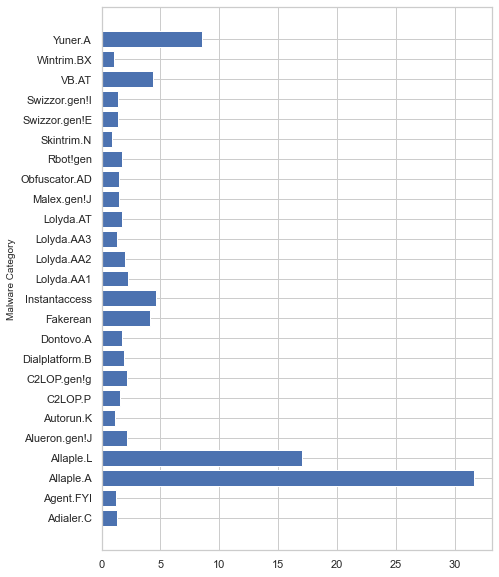

In [12]:
plt.figure(figsize=(7, 10))
plt.yticks(rotation='horizontal')
plt.ylabel('Malware Category', fontsize=10)
plt.rc('ytick', labelsize=12)
plt.barh(list(batches.class_indices.keys()),
         [x for x in ((sum(labels) / labels.shape[0]) * 100)])

In [30]:
pd.DataFrame({
    'Malware-Family':
    list(batches.class_indices.keys()),
    'Malware-Group': [
        'Dialer', 'Backdoor', 'Worm', 'Worm', 'Trojan', 'Worm AutoIT',
        'Trojan', 'Trojan', 'Dialer', 'Trojan Downloader', 'Rouge', 'Dialer',
        'PWS', 'PWS', 'PWS', 'PWS', 'Trojan', 'Trojan Downloader', 'Backdoor',
        'Trojan', 'Trojan Downloader', 'Trojan Downloader', 'Worm',
        'Trojan Downloader', 'Worm'
    ],
    'Malware-Indicator': [x for x in range(25)],
    'Count':
    pd.Series(list(sum(labels))).apply(int),
    '%-count':
    [str(round(x, 2))[:4] for x in ((sum(labels) / labels.shape[0]) * 100)]
}).style.hide_index()

Malware-Family,Malware-Group,Malware-Indicator,Count,%-count
Adialer.C,Dialer,0,122,1.31
Agent.FYI,Backdoor,1,116,1.24
Allaple.A,Worm,2,2949,31.5
Allaple.L,Worm,3,1591,17.0
Alueron.gen!J,Trojan,4,198,2.12
Autorun.K,Worm AutoIT,5,106,1.14
C2LOP.P,Trojan,6,146,1.56
C2LOP.gen!g,Trojan,7,200,2.14
Dialplatform.B,Dialer,8,177,1.9
Dontovo.A,Trojan Downloader,9,162,1.73


## Split Data into Train & Test 

### Scale Images 

In [31]:
scaled_imgs = imgs/255

### Split Data 

In [32]:
X_train, X_test, Y_train, Y_test = train_test_split(scaled_imgs,
                                                    labels,
                                                    test_size=0.2,
                                                    random_state=9,
                                                    shuffle=True)

# Visualize Train

In [34]:
def plots(ims, figsize=(20, 30), rows=10, cols=10, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
    f = plt.figure(figsize=figsize)
    for i in range(0, 50):
        sp = f.add_subplot(rows, cols, i + 1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(list(batches.class_indices.keys())[np.argmax(
                titles[i])],
                         fontsize=16)
        plt.imshow(ims[i], cmap='gray', vmin=0, vmax=255)

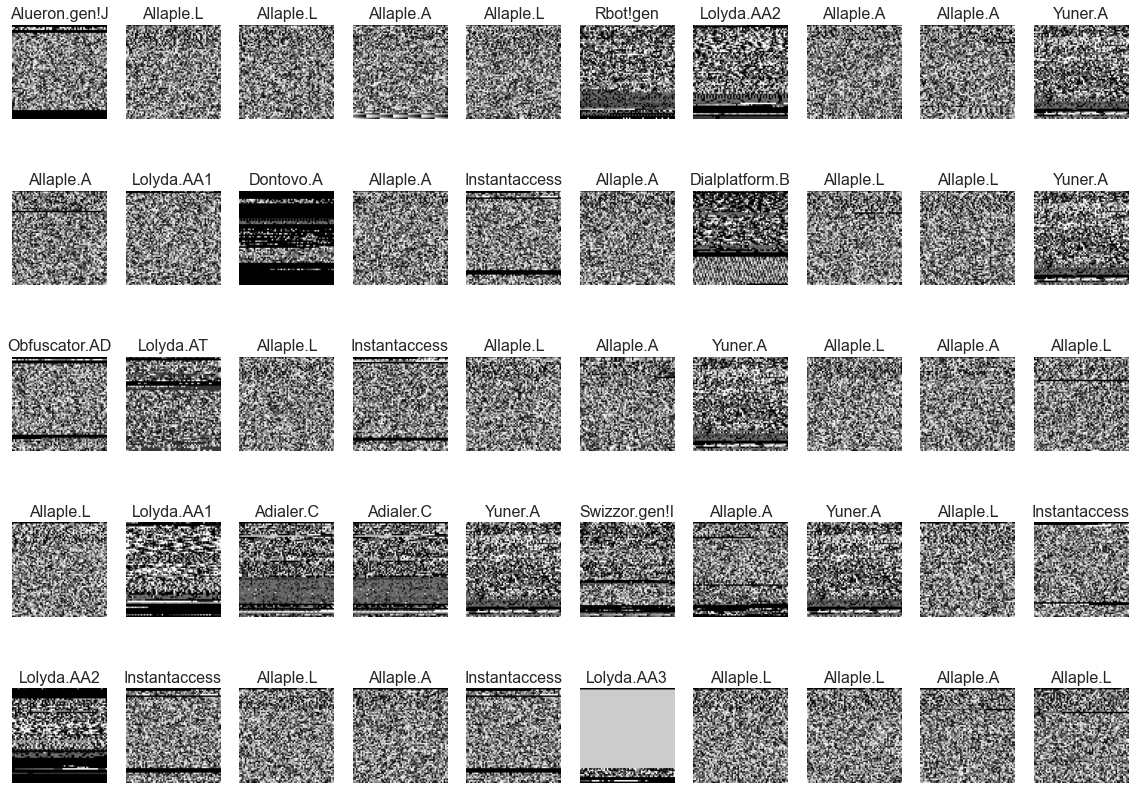

In [35]:
plots(imgs,titles=labels)

    ** This is portable executable file represented as black-white Image with different sections described as follows

![alt text](pe_file_as_image.png "pe")

# Experimentation 

    ** Idea is to extract important variant features using CNN architecture and convert it into image

## Hyper Space Definition

In [41]:
image_size = 64
patch_size = 5
num_patches = (image_size // patch_size)**2
projection_dim = 64
no_heads = 2
transformer_units = [projection_dim * 2, projection_dim]
transformer_layers = 4
mlp_head_units = [2048, 1024]

## Model Architecture

##### Class Weight

In [52]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(
    'balanced',
    np.unique(np.argmax(Y_train, axis=1)).tolist(), np.argmax(Y_train, axis=1))

##### Data Augmentation

In [42]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.Normalization(),
        layers.experimental.preprocessing.Resizing(image_size, image_size),
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(factor=0.02),
        layers.experimental.preprocessing.RandomZoom(height_factor=0.2,
                                                     width_factor=0.2),
    ],
    name="data_augmentation",
)
data_augmentation.layers[0].adapt(X_train)

In [43]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [48]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

In [44]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(input_dim=num_patches,
                                                   output_dim=projection_dim)

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [46]:
def cnn_vit_classifier():
    inputs = layers.Input(shape=(64, 64, 1))
    augmented = data_augmentation(inputs)
    augmented = layers.Conv2D(64, 7, strides=1, padding="same")(augmented)
    augmented = layers.BatchNormalization()(augmented)
    augmented = layers.Activation("relu")(augmented)
    augmented = layers.Conv2D(num_patches,
                              patch_size,
                              strides=1,
                              padding="same")(augmented)
    augmented = layers.BatchNormalization()(augmented)
    augmented = layers.Activation("relu")(augmented)
    patches = Patches(patch_size)(augmented)
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(num_heads=no_heads,
                                                     key_dim=projection_dim,
                                                     dropout=0.1)(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation,
                   hidden_units=mlp_head_units,
                   dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(25, activation='softmax')(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

In [49]:
model = cnn_vit_classifier()

In [50]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
data_augmentation (Sequential)  (None, 64, 64, 1)    3           input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 64, 64, 64)   3200        data_augmentation[1][0]          
__________________________________________________________________________________________________
batch_normalization_2 (BatchNor (None, 64, 64, 64)   256         conv2d_2[0][0]                   
______________________________________________________________________________________________

In [51]:
model.compile(optimizer=tfa.optimizers.AdamW(learning_rate=0.0003,
                                             weight_decay=0.00001),
              loss='categorical_crossentropy',
              metrics=[keras.metrics.categorical_accuracy])

In [53]:
history = model.fit(
    x=X_train,
    y=Y_train,
    batch_size=16,
    epochs=50,
    validation_data=(X_test, Y_test),
    class_weight={
        k: v
        for (k, v) in zip(
            np.unique(np.argmax(Y_train, axis=1)).tolist(), class_weights)
    },
    use_multiprocessing=True)

Epoch 1/50
467/467 [==============================] - 36s 59ms/step - loss: 4.0629 - categorical_accuracy: 0.2092 - val_loss: 1.9526 - val_categorical_accuracy: 0.2302
Epoch 2/50
467/467 [==============================] - 27s 57ms/step - loss: 1.4031 - categorical_accuracy: 0.4575 - val_loss: 1.8895 - val_categorical_accuracy: 0.3228
Epoch 3/50
467/467 [==============================] - 27s 57ms/step - loss: 0.9525 - categorical_accuracy: 0.5698 - val_loss: 5.0973 - val_categorical_accuracy: 0.1531
Epoch 4/50
467/467 [==============================] - 27s 57ms/step - loss: 0.8832 - categorical_accuracy: 0.5520 - val_loss: 4.5296 - val_categorical_accuracy: 0.1718
Epoch 5/50
467/467 [==============================] - 27s 58ms/step - loss: 0.7962 - categorical_accuracy: 0.5904 - val_loss: 2.4566 - val_categorical_accuracy: 0.2339
Epoch 6/50
467/467 [==============================] - 27s 58ms/step - loss: 0.6483 - categorical_accuracy: 0.6296 - val_loss: 1.4380 - val_categorical_accuracy:

467/467 [==============================] - 27s 57ms/step - loss: 0.2433 - categorical_accuracy: 0.8073 - val_loss: 0.3583 - val_categorical_accuracy: 0.8276
Epoch 50/50
467/467 [==============================] - 27s 58ms/step - loss: 0.2579 - categorical_accuracy: 0.8016 - val_loss: 0.3297 - val_categorical_accuracy: 0.8137


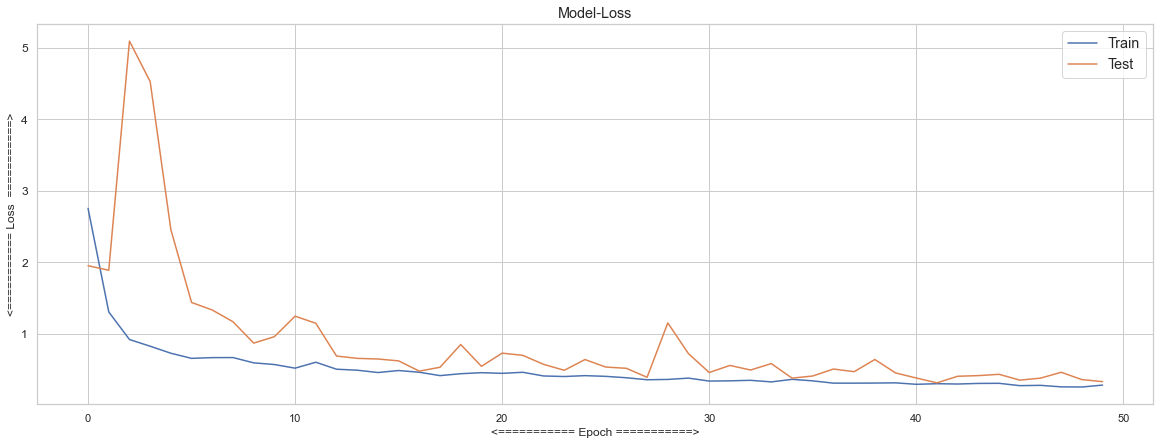

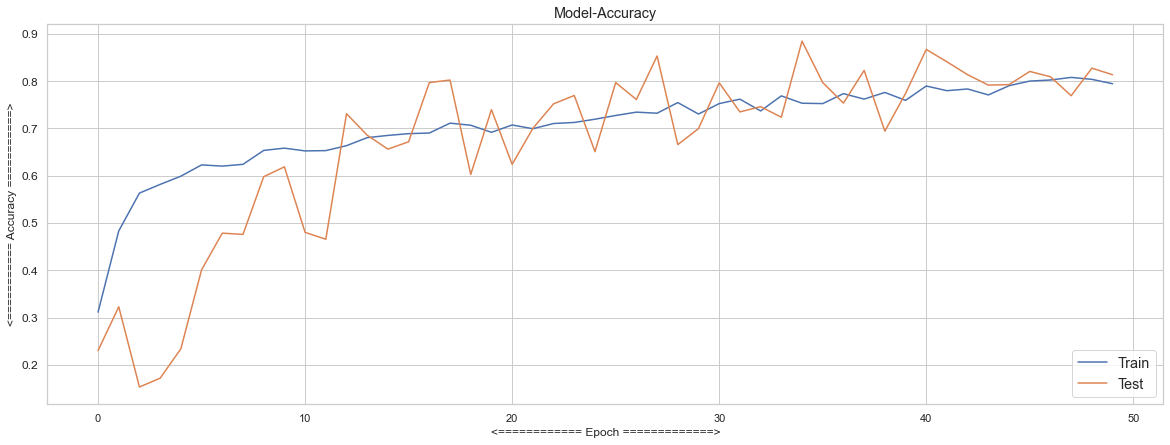

In [56]:
plt.figure(figsize=(20, 7))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model-Loss', fontsize='x-large')
plt.ylabel('<=========== Loss  ===========>', fontsize='large')
plt.xlabel('<=========== Epoch ===========>', fontsize='large')
plt.legend(['Train', 'Test'], loc='upper right', fontsize='x-large')
plt.rc('ytick', labelsize=12)
plt.show()
plt.figure(figsize=(20, 7))
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('Model-Accuracy', fontsize='x-large')
plt.ylabel('<=========== Accuracy ===========>', fontsize='large')
plt.xlabel('<============ Epoch =============>', fontsize='large')
plt.legend(['Train', 'Test'], fontsize='x-large', loc='lower right')
plt.show()

# Model Evaluate 

In [57]:
y_train_pred = model.predict(X_train, workers=-1, use_multiprocessing=True)
y_test_pred = model.predict(X_test, workers=-1, use_multiprocessing=True)

## Train 

In [58]:
np.round(
    evaluate_model(
        np.argmax(Y_train, axis=1).tolist(),
        np.argmax(y_train_pred, axis=1).tolist()) * 100, 2)

,Reccall,Precision,False_Positive_Rate,False_Negative_Rate,Accuracy,F1_Score
overall,83.108,83.108,0.70,16.89,98.65,83.108
0,100,100,0.00,0.00,100.00,100
1,100,100,0.00,0.00,100.00,100
2,95.69,82.94,9.13,4.31,92.40,88.86
3,64.29,99.52,0.06,35.71,93.78,78.12
4,100,93.49,0.15,0.00,99.85,96.64
5,100,11.67,8.50,0.00,91.59,20.91
6,94.5,89.57,0.16,5.50,99.76,91.96
7,89.38,100,0.00,10.62,99.77,94.39
8,100,100,0.00,0.00,100.00,100


In [61]:
print(sklearn.metrics.classification_report(
    np.argmax(Y_train, axis=1).tolist(),
    np.argmax(y_train_pred, axis=1).tolist()))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       102
           1       1.00      1.00      1.00        92
           2       0.83      0.96      0.89      2368
           3       1.00      0.64      0.78      1291
           4       0.93      1.00      0.97       158
           5       0.12      1.00      0.21        83
           6       0.90      0.94      0.92       109
           7       1.00      0.89      0.94       160
           8       1.00      1.00      1.00       135
           9       1.00      1.00      1.00       127
          10       1.00      0.99      1.00       317
          11       1.00      1.00      1.00       332
          12       0.93      0.98      0.95       169
          13       0.99      0.97      0.98       143
          14       1.00      1.00      1.00       102
          15       1.00      0.99      1.00       131
          16       0.55      0.99      0.71       108
          17       0.99    

## Test

In [62]:
np.round(
    evaluate_model(
        np.argmax(Y_test, axis=1).tolist(),
        np.argmax(y_test_pred, axis=1).tolist()) * 100, 2)

,Reccall,Precision,False_Positive_Rate,False_Negative_Rate,Accuracy,F1_Score
overall,81.3704,81.3704,0.78,18.63,98.51,81.3704
0,100,100,0.00,0.00,100.00,100
1,100,100,0.00,0.00,100.00,100
2,96.56,82.99,8.94,3.44,92.77,89.26
3,63,100,0.00,37.00,94.06,77.3
4,97.5,92.86,0.16,2.50,99.79,95.12
5,100,11.68,9.43,0.00,90.69,20.91
6,86.49,74.42,0.60,13.51,99.14,80
7,75,93.75,0.11,25.00,99.36,83.33
8,100,100,0.00,0.00,100.00,100


In [63]:
print(sklearn.metrics.classification_report(
    np.argmax(Y_test, axis=1).tolist(),
    np.argmax(y_test_pred, axis=1).tolist()))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       1.00      1.00      1.00        24
           2       0.83      0.97      0.89       581
           3       1.00      0.63      0.77       300
           4       0.93      0.97      0.95        40
           5       0.12      1.00      0.21        23
           6       0.74      0.86      0.80        37
           7       0.94      0.75      0.83        40
           8       1.00      1.00      1.00        42
           9       1.00      1.00      1.00        35
          10       1.00      0.98      0.99        64
          11       1.00      0.99      0.99        99
          12       0.90      1.00      0.95        44
          13       0.98      0.98      0.98        41
          14       1.00      1.00      1.00        21
          15       1.00      0.96      0.98        28
          16       0.59      0.93      0.72        28
          17       1.00    

In [67]:
sklearn.metrics.accuracy_score(
    np.argmax(Y_test, axis=1).tolist(),
    np.argmax(y_test_pred, axis=1).tolist())

0.8137044967880086

# Model Dump-Yard